<span style="font-size:2.5em;">**Infer nebular properties and the ionizing spectrum from emission lines**</span>

This is an example of fitting galaxy emission lines with Cue.

In [1]:
# import functions
import numpy as np
import dill as pickle
import matplotlib
from matplotlib import pyplot as plt
from pkg_resources import resource_filename
import cue
from cue.line import predict
from cue.utils import (c, cont_lam, new_sorted_line_name, 
                       logQ, Qtotal,
                       get_loglinear_spectra, ionparam2norm, calcQ) # this includes some constants and functions for the fits and output plots

/tmp/ipykernel_2048805/3946065125.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
2025-10-28 12:10:52.249822: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-28 12:10:52.250140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 12:10:52.296058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 12})

# Read the observed line luminosities and uncertainties of a galaxy at z=6 (from Cameron+2024). The line luminosities are in erg/s.

Here we take some line measurements of GS9422 from Cameron et al. (2024) ([10.48550/arXiv.2311.02051](https://ui.adsabs.harvard.edu/abs/2023arXiv231102051C/abstract)). 

The input emission lines should be in the order of the obs["line_name"]. obs["line_lum"] are the detected emission line luminosities in erg/s. obs["line_lum_up"] are the 3 sigma upper limits of some undetected emission lines. obs["line_lum_unc"] are 1 sigma uncertainty of the line luminosities or the 1 sigma upper limits. All luminosities are in rest-frame and have been dust-corrected.

In [3]:
with open("./demo_data.pkl", 'rb') as f:
    obs = pickle.load(f)
obs.keys()

dict_keys(['z', 'line_name', 'line_wav', 'line_lum', 'line_lum_up', 'line_lum_unc'])

In [12]:
obs["line_lum_up"]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.02484249e+41, 0.00000000e+00, 7.78880292e+40, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.27949597e+40, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

The emulator error are <~5% for most emission lines. For some high ionization state lines, their errors are >20%. We might add in some emulator uncertainties to the line flux uncertainties.

In [4]:
# S/N of the observation
wav_ind, = np.where((obs['line_lum']!=0) | (obs['line_lum_up']!=0))
wav_ind_obs, = np.where(obs['line_lum']!=0)
wav_ind_up, = np.where(obs['line_lum_up']!=0)

SN_obs = np.zeros_like(obs['line_lum'])
SN_obs[wav_ind_obs] = obs['line_lum'][wav_ind_obs]/obs['line_lum_unc'][wav_ind_obs] 
SN_obs[wav_ind_up] = 3

# S/N of the emulator test data set, here the noise is the emulator uncertainty
with open(resource_filename("cue", "data/nn_stats_v0.pkl"), 'rb') as f:
       nn_stats = pickle.load(f)
SN_nn = nn_stats['SN_quantile'][1][np.argsort(nn_stats['wav'])]

# combine the observed SN and the emulator SN to estimate the noise for the measured lines
SN_obs[wav_ind_obs] = 1./np.sqrt(1./SN_obs[wav_ind_obs]**2 + 1./SN_nn[wav_ind_obs]**2)
line_noise = np.zeros_like(obs['line_lum'])
line_noise[wav_ind_obs] = (obs['line_lum'][wav_ind_obs]/SN_obs[wav_ind_obs])
line_noise[wav_ind_up] = obs['line_lum_unc'][wav_ind_up]
line_var = line_noise**2

# Sample the posterior of Cue parameters using dynesty.

dynesty implements dynamic nested sampling. Here we change some dynesty settings for the sampling process.

In [6]:
from dynesty import NestedSampler
from dynesty import DynamicNestedSampler
import warnings
warnings.filterwarnings("ignore")

dargs = {
        'bound': 'multi',
        'sample': 'rwalk',
        'nlive': 500,
        'wt_kwargs': {'pfrac': 1.0},
        'dlogz': 0.01,
        'update': {'min_ncall': 10000, 'min_eff': 10.},
        'maxcall': int(1.e7),
        'update_interval': float(50),
        'walks': 25
       }

import multiprocessing as mp
nparallel = 4 # running dynesty in parallel

Prior of the Cue parameters. The first 7 parameters define the 4 piece-wise power-law ionizing spectrum. The rest parameters include ionization parameter log $U$, gas density log $n_H$, gas-phase metallicity [O/H], [N/O], [C/O], and the effective ionizing photon rate log $Q_{ion}$. The last parameter, log $Q_{ion}$ is a scaling parameter that normalizes the output nebular emission lines and continuum by the 
$Q_{ion}$/$Q_H$($U$, $n_H$). Here we adopt uniform priors spanning the full training set range.

In [7]:
def prior_transform(model_params):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)` to the parameter of interest."""
    un0, un1, un2, un3, un4, un5, un6, un7, un8, un9, un10, un11, un12 = model_params
    n0 = 20.5 * (2*un0 - 1) + 21.5
    n1 = 15.15 * (2*un1 - 1) + 14.85
    n2 = 7.55 * (2*un2 - 1) + 6.45
    n3 = 4.85 * (2*un3 - 1) + 3.15
    n4 = 5.55 * (2*un4 - 1) + 4.55
    n5 = 1.2 * (2*un5 - 1) + 0.7
    n6 = 1.25 * (2*un6 - 1) + 0.85
    n7 = 1.5 * (2*un7 - 1) - 2.5  #logU
    n8 = 1.5 * (2*un8 - 1) + 2.5  #lognH (cm^-3)
    n9 = 1.35 * (2*un9 - 1) - 0.85  #gas_logZ
    n10 = 0.5*(np.log10(5.4)+1) * (2*un10 - 1) + 0.5*(np.log10(5.4)-1)  #log N/O
    n11 = 0.5*(np.log10(5.4)+1) * (2*un11 - 1) + 0.5*(np.log10(5.4)-1)  #log C/O
    n12 = 10 * (2*un12 - 1) + 50  #effective logQ for normalization
    return n0, n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12

A Gaussian likelihood for the emission lines.

In [26]:
def loglike_cue(model_params):
    # transform the parameters to the input parameters of Cue
    model_params[7] = logQ(model_params[7], lognH=model_params[8]) # convert log U to log QH(U, nH)
    model_params[8] = 10**model_params[8] # convert log nH to nH
    
    # get the line predictions from Cue
    fit = predict(theta=np.array(model_params[:12]).reshape(1, 12), 
                  line_ind=np.arange(138)).nn_predict()[1]/10**model_params[7]*10**model_params[12]
    
    # calculate the Gaussian likelihood
    delta = np.zeros(138)
    delta[wav_ind_obs] = obs['line_lum'][wav_ind_obs]-fit[wav_ind_obs]
    delta[wav_ind_up] = 0-fit[wav_ind_up]
    delta = delta[wav_ind]
    lnp = -0.5*( (delta**2/line_var[wav_ind]) + np.log(2*np.pi*line_var[wav_ind]) )
    return lnp.sum()

# Sample the posterior

Sample the posterior. Each Cue prediction takes ~6ms. Depending on the dynesty settings and the computing resources, this process might take ~30min.  

In [23]:
print(prior_transform)  # wtf are the model params
print(dargs['sample'])
print(dargs['update'])
print(dargs['nlive'])

<function prior_transform at 0x7735781bc900>
rwalk
{'min_ncall': 10000, 'min_eff': 10.0}
500


In [ ]:
pool = mp.Pool(nparallel)
cue_sampler = DynamicNestedSampler(loglike_cue, prior_transform, 
                                   # log likelihood function, function translating a unit cube to the parameter space
                                   ndim=13, # number of dimensions
                                   sample=dargs['sample'], # method used to sample the libelihood (probably rwalk)
                                   first_update=dargs['update'], # dictionary with parameters governing when the sampler should first update the bounding distribution form the unit cube
                                   bound=dargs['bound'], # method used to approximately bound the prior using the current set of live points
                                   nlive=dargs['nlive'], # number of 'live' points
                                   update_interval=dargs['update_interval'], # only update the proposal distribution after this many calls
                                   pool=pool, # use this pool of workers to execute operations in parallel
                                   queue_size=nparallel, # carry out likelihood evaluations in parallel by queueing up new live point proposals using this many threads
                                  )
# what are the actual model_params that are run in loglike_cue and prior_transform??
cue_sampler.run_nested(maxcall=dargs['maxcall'])
cue_results = cue_sampler.results
with open("demo_res.pkl", 'wb') as f:
    pickle.dump(cue_results, f)
pool.close()

24792it [06:41, 61.68it/s, batch: 4 | bound: 5 | nc: 1 | ncall: 745941 | eff(%):  3.254 | loglstar: -2749.338 < -2740.815 < -2742.844 | logz: -2769.492 +/-  0.174 | stop:  0.817]      


In [14]:
print("max iterations?", dargs['maxcall'])

max iterations? 10000000


# Plot the fit results

Translate the power-law parameters to the ionizing spectrum $F_\nu$ posterior. We can also calculate the posterior of the ionizing photon output at each bin.

In [15]:
# Here ionparam2norm() calculate the power-law indexes and normalizations from the Cue parameters
# It does the conversion of the ratios of the power-law segments to the normalizations.
# get_loglinear_spectra() calculates the 4-segment power-law ionizing spectrum based on the power-law parameters.
# We then renormalize the ionizing spectrum based on the Q(U, nH) to get the inferred ionizing spectrum shape.
# The Qtotal function calculate the ionizing photon output at each segment given the power-law parameters. We scale Qs to match with total Qion
wavelength = np.load(resource_filename("cue", "data/Powerlaw_wavelength.npy")) # a wavelength grid at 1-2000AA, can be replaced with a different grid
posterior_Fnu = list()
posterior_Qs = list()

for this_par in cue_results['samples']:
    this_spec = get_loglinear_spectra(wavelength, ionparam2norm(this_par)[0])
    Qnorm = calcQ(wavelength, this_spec[:len(wavelength)])
    this_spec[:len(wavelength)] = this_spec[:len(wavelength)]*\
                                  10**logQ(this_par[7], lognH=this_par[8])/Qnorm
    this_Qs = 10**Qtotal(ionparam2norm(this_par)[0])
    posterior_Qs.append(10**this_par[12]/np.sum(this_Qs)*this_Qs)
    posterior_Fnu.append(this_spec)

posterior_Fnu = np.array(posterior_Fnu)
posterior_Qs = np.array(posterior_Qs)

Plot the posterior of the ionizing spectrum and nebular properties. For this object with 29 detected lines, Cue can constrain the ionizing photon output at each power-law segment and the nebular parameters. The power-law indexes are not well constrained since they only have second-order effect on the ionizing spectrum shape and we need more high S/N lines to infer the indexes.

In [16]:
# draw 2000 samples from the posterior ionizing spectrum
from cue.utils import (c, cont_lam, new_sorted_line_name, 
                       logQ, Qtotal,
                       get_loglinear_spectra, ionparam2norm, calcQ) # this includes some constants and functions for the fits and output plots
dynesty_weights = np.exp(cue_results.logwt-cue_results.logz[-1])
sample_ionizing_spectra = posterior_Fnu[np.random.choice(len(cue_results.samples), size=2000,
                                                        p = dynesty_weights)] * (c/wavelength**2)
best_ionizing_spectrum = posterior_Fnu[-1] * (c/wavelength**2)

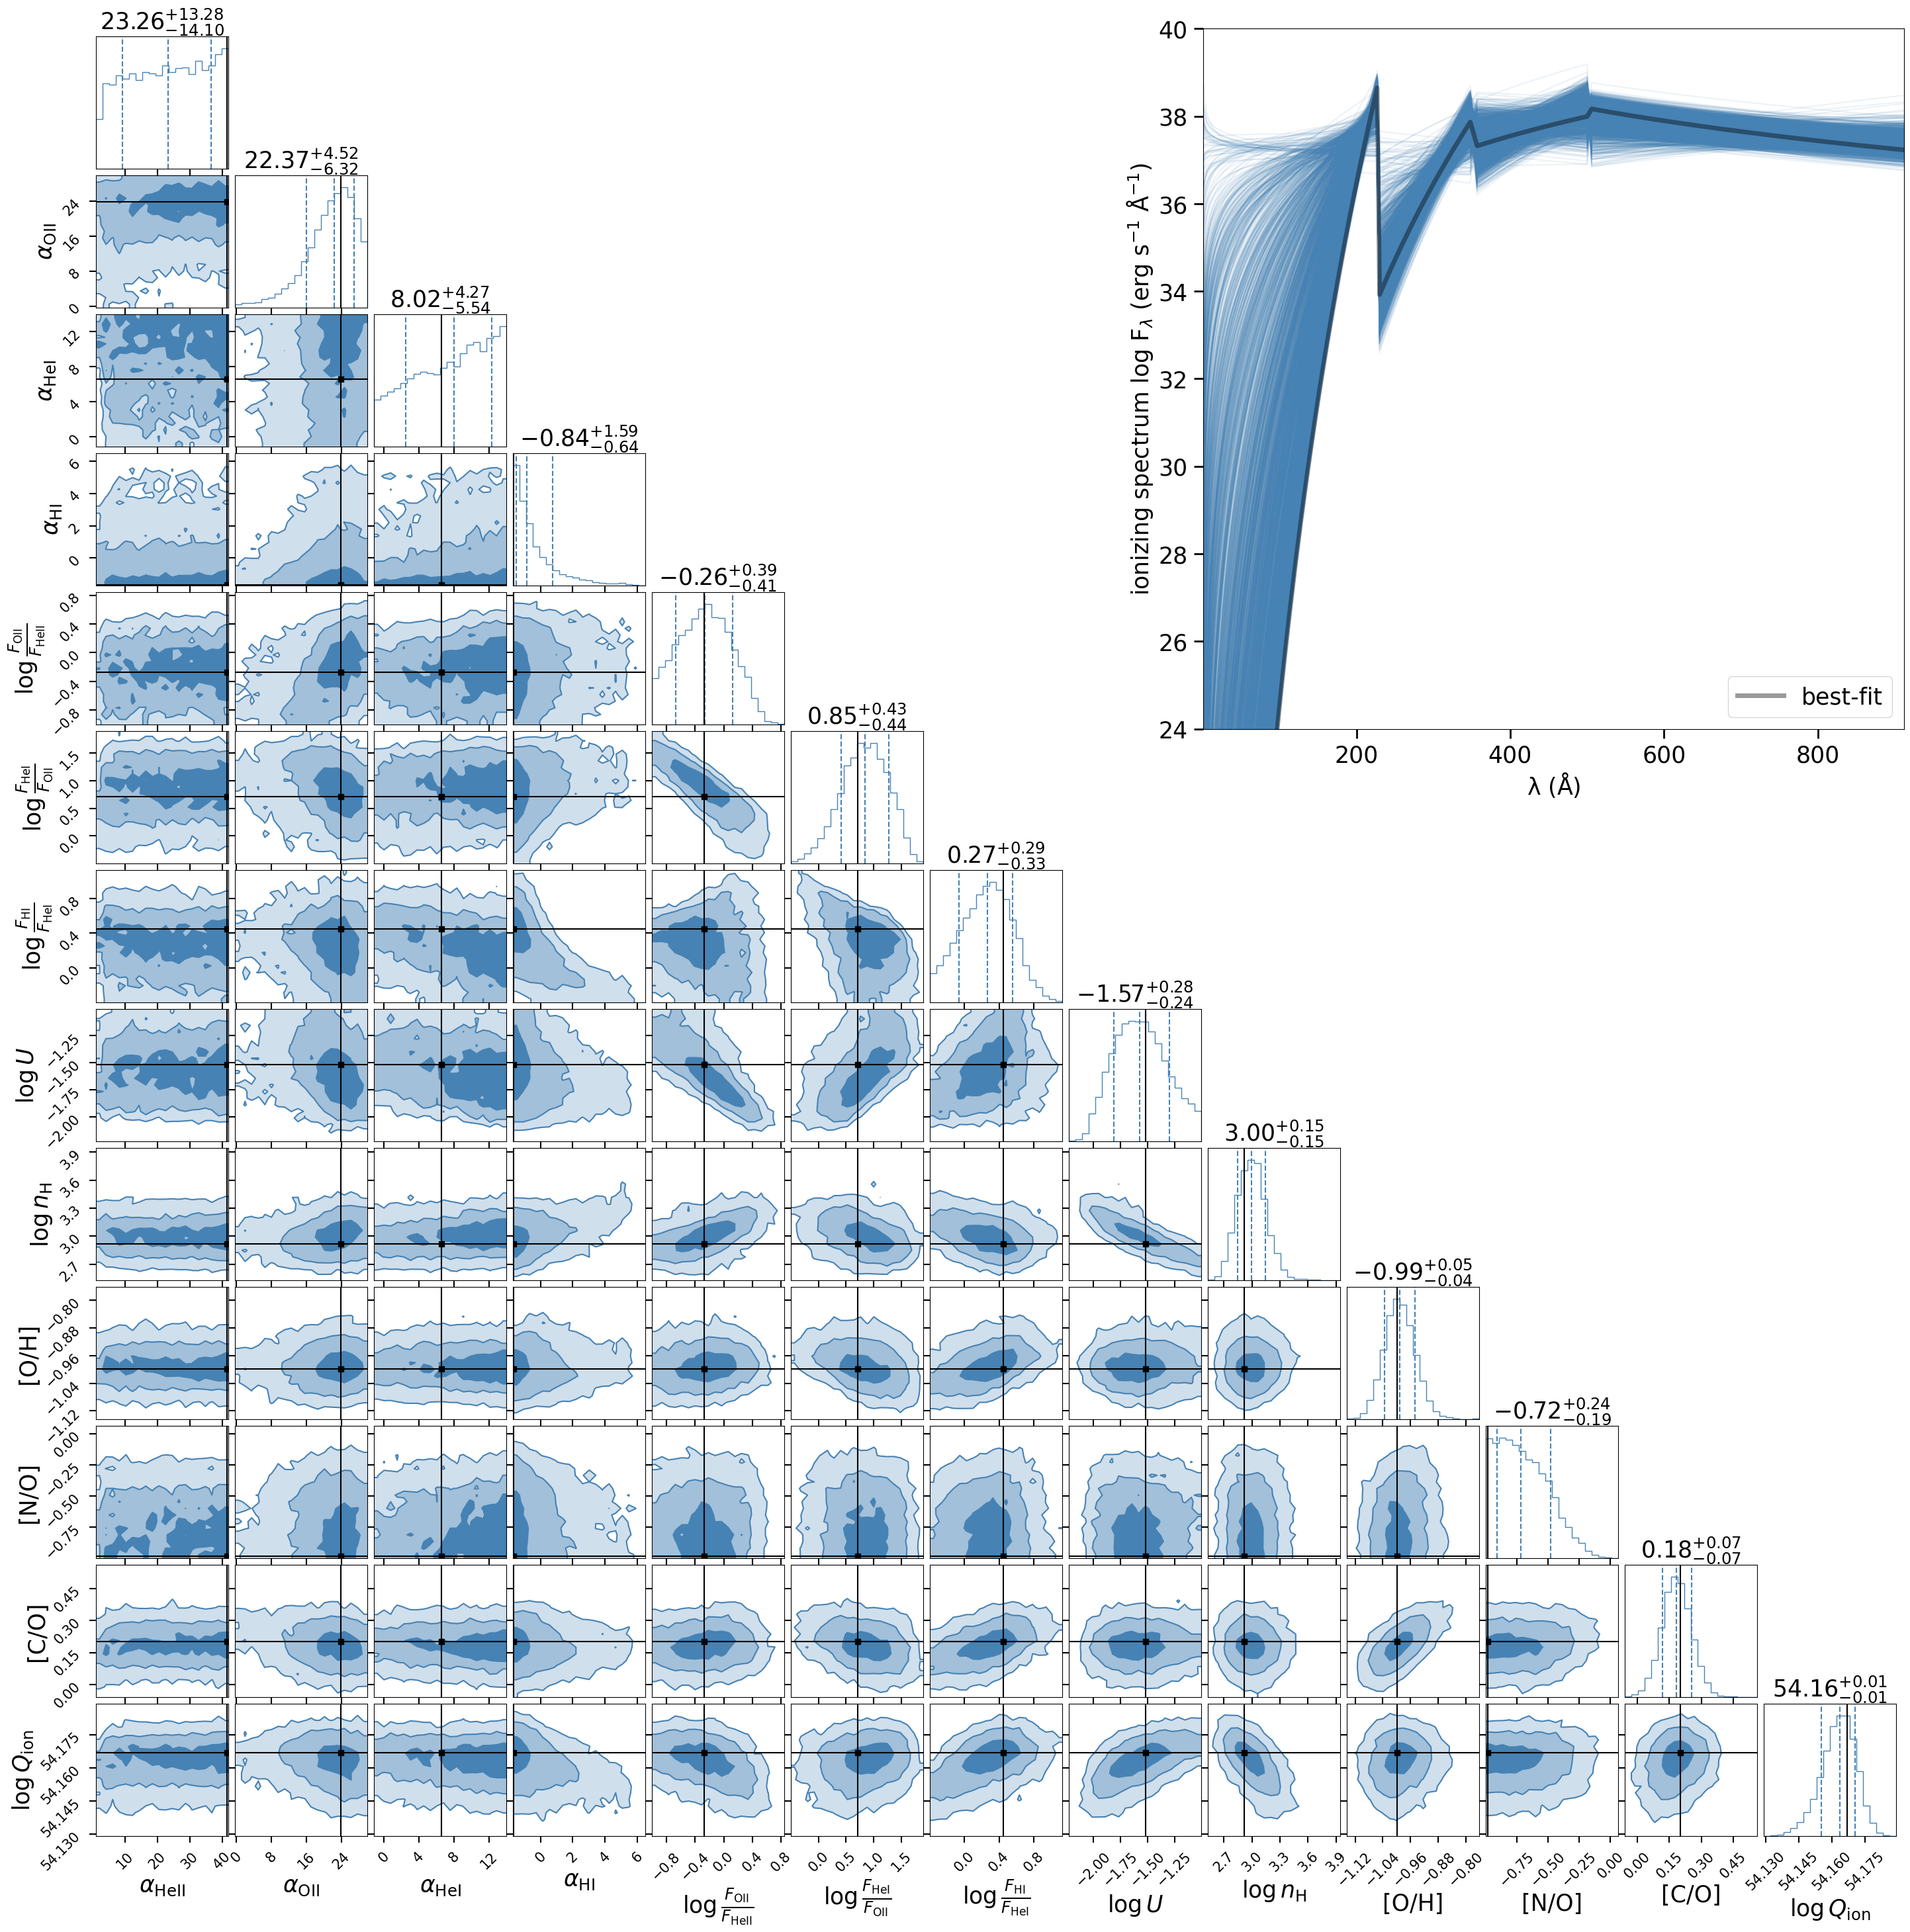

In [17]:
# corner plot of the posterior and the ionizing spectrum posterior
import corner
sigmas = 1 - np.exp(-np.array([1,2,3])**2/2) #corresponding to 1,2,3 sigmas
labels = [r'$\alpha_\mathrm{HeII}$', r'$\alpha_\mathrm{OII}$', 
          r'$\alpha_\mathrm{HeI}$', r'$\alpha_\mathrm{HI}$',
          r'$\log \frac{F_\mathrm{OII}}{F_\mathrm{HeII}}$', 
          r'$\log \frac{F_\mathrm{HeI}}{F_\mathrm{OII}}$', 
          r'$\log \frac{F_\mathrm{HI}}{F_\mathrm{HeI}}$',
          r'$\log U$', r'$\log n_\mathrm{H}$', 
          r'[O/H]', 
          r'[N/O]', 
          r'[C/O]',
          r'$\log Q_\mathrm{ion}$'
         ]

# define a plot range
from dynesty.utils import resample_equal
plot_min, plot_max = np.quantile(resample_equal(cue_results['samples'], 
                                                              np.exp(cue_results['logwt']-cue_results['logz'][-1])), 
                                 [0, 1], axis=0)
plot_range = [[np.min([cue_results['samples'][-1][i], plot_min[i]]), 
               np.max([cue_results['samples'][-1][i], plot_max[i]])] for i in range(len(plot_min))]

# make corner plot
fig = corner.corner(cue_results['samples'],
                    bins = 20,
                    weights=np.exp(cue_results['logwt']-cue_results['logz'][-1]),
                    truths = cue_results['samples'][-1], 
                    truth_color= 'k',
                    #title_quantiles = [0.025, 0.5, 0.975],
                    quantiles = [0.16, 0.5, 0.84], #[0.025, 0.5, 0.975],
                    #verbose = True,
                    color='#4682b4', 
                    show_titles=True, 
                    title_kwargs={"fontsize": 25}, 
                    label_kwargs={"size":25}, 
                    #max_n_ticks=7, 
                    range = plot_range,
                    alpha=0.6,
                    levels=sigmas, 
                    plot_datapoints=False,
                    plot_density=False,
                    fill_contours=True,
                   )
[ax.tick_params(labelsize=15) for ax in fig.get_axes()]
axes = np.array(fig.axes).reshape((len(cue_results['samples'][-1]), 
                            len(cue_results['samples'][-1])))
for i in range(12):
    axes[i+1, 0].set_ylabel(labels[i+1], size=25)
for i in range(13):
    axes[-1, i].set_xlabel(labels[i], size=25)

# plot ionizing spectrum posterior
left, bottom, width, height = [0.62, 0.62, 0.37, 0.37]
ax2 = fig.add_axes([left, bottom, width, height])
for i in range(2000):
    ax2.plot(wavelength, np.log10(sample_ionizing_spectra[i]), alpha=0.1, c='#4682b4')
ax2.plot(wavelength, np.log10(best_ionizing_spectrum), alpha=0.4, c='k', lw=5, label='best-fit')
ax2.set_xlim(1,912)
ax2.set_ylim(24, 40)
ax2.legend(loc='lower right', prop={'size':25})
ax2.set_xlabel(r'$\mathrm{\lambda}$ ($\mathrm{\AA}$)', size=25)
ax2.set_ylabel(r'ionizing spectrum log $\mathrm{F}_\lambda$ (erg s$^{-1}$ $\mathrm{\AA}^{-1}$)', size=25);
ax2.tick_params(labelsize=25, length=10, width=2)

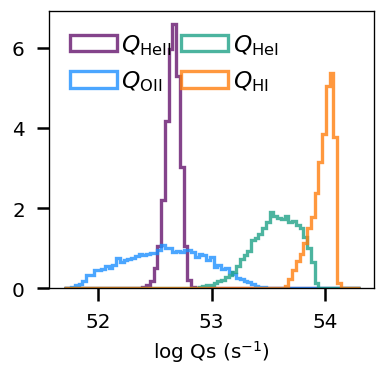

In [18]:
# We can also plot the inferred ionizing photon outputs at each power-law bin
plt.figure(figsize=(3.5,3), dpi=120)
plt.hist(np.log10(posterior_Qs[:,0]), weights = dynesty_weights, color='#65156e', 
         density=True, histtype='step', bins=np.linspace(51.7, 54.3, 80),
         label=r'$Q_\mathrm{HeII}$', alpha=0.8, lw=2)
plt.hist(np.log10(posterior_Qs[:,1]), weights = dynesty_weights, color='dodgerblue', 
         density=True, histtype='step', bins=np.linspace(51.7, 54.3, 80),
         label=r'$Q_\mathrm{OII}$', alpha=0.8, lw=2)
plt.hist(np.log10(posterior_Qs[:,2]), weights = dynesty_weights, color='#1fa187', 
         density=True, histtype='step', bins=np.linspace(51.7, 54.3, 80),
         label=r'$Q_\mathrm{HeI}$', alpha=0.8, lw=2)
plt.hist(np.log10(posterior_Qs[:,3]), weights = dynesty_weights, color='C1', 
         density=True, histtype='step', bins=np.linspace(51.7, 54.3, 80),
         label=r'$Q_\mathrm{HI}$', alpha=0.8, lw=2)

plt.legend(framealpha=0., loc='upper left', ncol=2, columnspacing=0.4, handletextpad=0.2, prop={'size':14})
plt.xlabel(r'log Qs (s$^{-1}$)');

Calculate and plot the nebular emission line and continuum posterior.

In [ ]:
# median and 1-sigma range of the emission line and nebular continuum
from dynesty.utils import resample_equal
theta_arr = resample_equal(cue_results.samples, np.exp(cue_results.logwt-cue_results.logz[-1]), rstate=None)

# predict lines from ???
line_pred = list()
cont_pred = list()
for ind in range(len(theta_arr)):
    par = theta_arr[ind].copy()
    par[7] = logQ(par[7], lognH=par[8])
    par[8] = 10**par[8]
    line_pred.append(predict(theta=np.array(par[:12]).reshape(1, 12), 
                             line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12])
    cont_pred.append(cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/\
    10**par[7]*10**par[12])


low_line, med_line, up_line = np.quantile(np.array(line_pred), [0.16, 0.5, 0.84], axis=0)
low_cont, med_cont, up_cont = np.quantile(np.array(cont_pred), [0.16, 0.5, 0.84], axis=0)

par = cue_results['samples'][-1].copy()
log_Ltotal = np.zeros(4)
par[7] = logQ(par[7], lognH=par[8])
par[8] = 10**par[8]
best_line_pred = predict(theta=np.array(par[:12]).reshape(1, 12), 
                         line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12]
best_cont_pred = cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/10**par[7]*10**par[12]

In [14]:
# goodness of fit function for emission lines. 
# The noise here is only the observational noise, different than the one in likelihood function, where we also account for the emulator noise.
def chi_lines(fit):
    chi = np.zeros_like(obs["line_lum"])
    chi[wav_ind_obs] = (fit[wav_ind_obs]-obs["line_lum"][wav_ind_obs]) / obs["line_lum_unc"][wav_ind_obs]
    chi[wav_ind_up] = (fit[wav_ind_up]-0) / obs["line_lum_unc"][wav_ind_up]
    
    chisq = np.sum(chi**2)
    ndof = len(chi[wav_ind])
    reduced_chisq = chisq/(ndof)

    return reduced_chisq, chi

In [15]:
# define line labels of the emission lines for the plots
round_to_n = lambda x, n: x if x == 0 else round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))
def formatNumber(num):
    if num % 1 == 0:
        return str(int(num))
    else:
        return str(num)
    
shortened_sorted_line_name = list()
for i in range(len(new_sorted_line_name)):
    new_name = new_sorted_line_name[i][:5] + \
    formatNumber(round_to_n(float(new_sorted_line_name[i][5:12]), 4)) + \
    new_sorted_line_name[i][12]
    if new_name[-1] == 'A':
        new_name = new_name[:-1] + r'$\mathrm{\AA}$'
    if new_name[-1] == 'm':
        new_name = new_name[:-1] + r'$\mathrm{\mu}$m'
    shortened_sorted_line_name.append(new_name)
shortened_sorted_line_name = np.array(shortened_sorted_line_name)

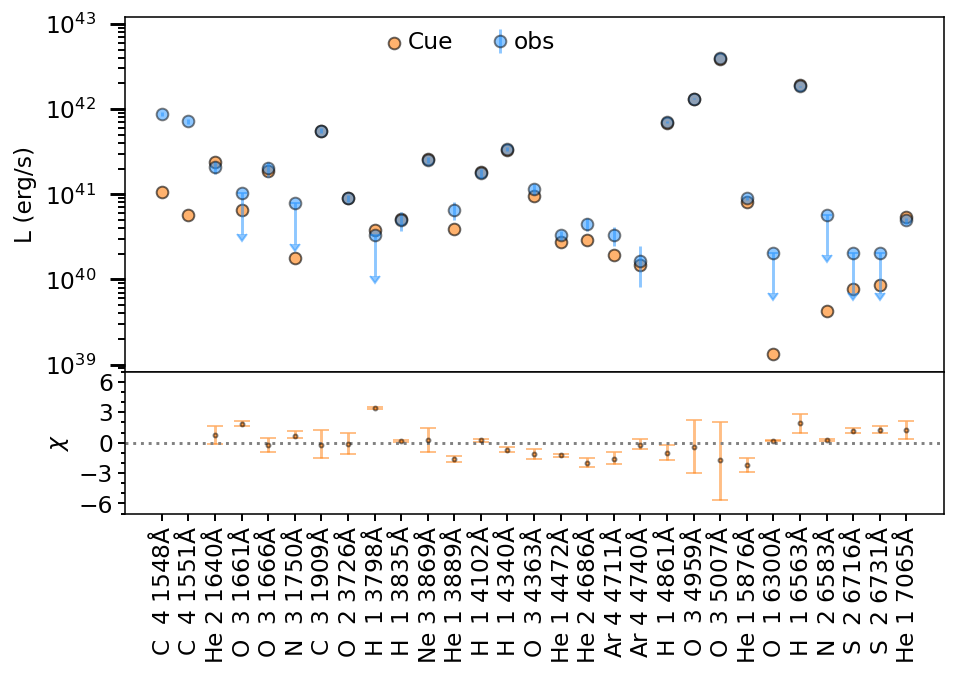

In [16]:
# plot emission line prediction
fig, ([line_lum_ax,line_lum_resid_ax]) = plt.subplots(2, 1, #sharex=True, 
                                            gridspec_kw={'height_ratios': [3, 1.2],
                                                          'hspace': 0.},
                                            figsize=(7,5.), dpi=140)

linechi_low = chi_lines(low_line)[1]
linechi_up = chi_lines(up_line)[1]
linechi_med = chi_lines(med_line)[1]
#reduced_chisq = chi_lines(med_line)[0]

for ind in wav_ind:
    if ind in wav_ind_obs:
        if ind == wav_ind_obs[0]:
            line_lum_ax.errorbar(shortened_sorted_line_name[ind], obs["line_lum"][ind], yerr=obs["line_lum_unc"][ind],
             marker='o', ls=' ', color='dodgerblue', markeredgecolor='k', alpha=0.5,
             label="obs")
        else:
            line_lum_ax.errorbar(shortened_sorted_line_name[ind], obs["line_lum"][ind], yerr=obs["line_lum_unc"][ind],
             marker='o', ls=' ', color='dodgerblue', markeredgecolor='k', alpha=0.5)
    if ind in wav_ind_up:
        line_lum_ax.errorbar(shortened_sorted_line_name[ind], obs["line_lum_up"][ind], yerr=obs["line_lum_up"][ind]/1.5,
             marker='o', ls=' ', uplims=True, color='dodgerblue', markeredgecolor='k', alpha=0.5, capsize=2.5)
line_lum_ax.scatter(shortened_sorted_line_name[wav_ind], med_line[wav_ind],
                    marker='o', color='C1', edgecolor='k', alpha=0.6,
                    label="Cue")

line_lum_ax.legend(framealpha=0., handletextpad=0.08, labelspacing=0.05, 
                   ncol=2, columnspacing=1.5, handlelength=1.0, 
                   loc='upper center', bbox_to_anchor=(0.42, 1.02)); 
line_lum_ax.set_ylabel(r'L (erg/s)')
line_lum_ax.set_yscale('log')
line_lum_ax.set_ylim(line_lum_ax.get_ylim()[0]*0.92, line_lum_ax.get_ylim()[1]*2)
line_lum_ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
line_lum_ax.tick_params(axis="x", labelbottom=False)

line_lum_resid_ax.sharex(line_lum_ax)
line_lum_resid_ax.errorbar(shortened_sorted_line_name[wav_ind], linechi_med[wav_ind],
                           yerr=[linechi_med[wav_ind]-linechi_low[wav_ind], linechi_up[wav_ind]-linechi_med[wav_ind]],
                           color='C1', marker='o', markersize=2, linestyle=' ', 
                           markeredgecolor='k', alpha=0.5, capsize=4,)
resid_ymax = np.min([np.abs(line_lum_resid_ax.get_ylim()).max()*1.05,7])
line_lum_resid_ax.set_ylim(-resid_ymax,resid_ymax)
line_lum_resid_ax.tick_params('both', pad=2.5, size=3.5, width=1.0, which='both')
line_lum_resid_ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5))
line_lum_resid_ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
line_lum_resid_ax.tick_params(which='minor', length=2)
line_lum_resid_ax.set_ylabel(r'$\chi$');
# extra line
line_lum_resid_ax.axhline(0, linestyle=':', color='grey')
plt.xticks(rotation=90);

plt.tight_layout()

We can fit all lines within ~3 sigma except for the CIV λλ1548, 1551 resonant lines. CIV λλ1548, 1551 have large emulator uncertainties that have been included in the likelihood function. We allow those lines to deviate more from the observed value since our model is uncertain on them.

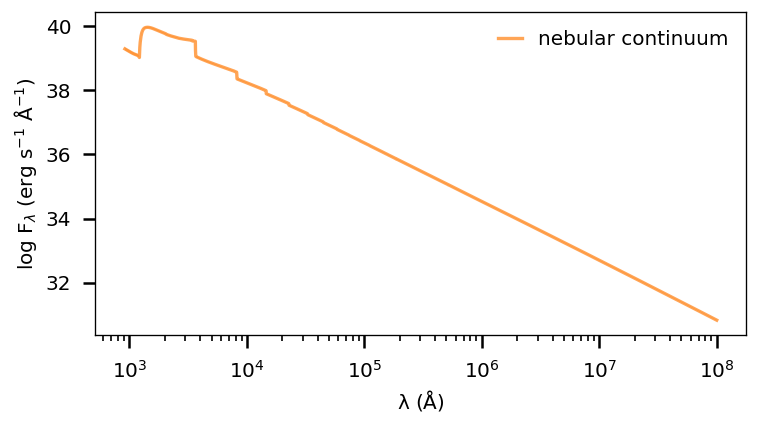

In [17]:
# plot nebular continuum prediction
plt.figure(figsize=(7,3.5), dpi=120)
plt.plot(cont_lam[cont_lam>912],
         np.log10(med_cont*c/cont_lam[cont_lam>912]**2),
         color='C1', lw=2, alpha=0.7, label='nebular continuum')
plt.fill_between(cont_lam[cont_lam>912], 
                 y1=np.log10(low_cont*c/cont_lam[cont_lam>912]**2),
                 y2=np.log10(up_cont*c/cont_lam[cont_lam>912]**2),
                 facecolor='C1', edgecolor=None, alpha=0.4)
plt.xscale('log')
plt.legend(framealpha=0., handlelength=1.2)
plt.xlabel(r'$\mathrm{\lambda}$ ($\mathrm{\AA}$)', size=12)
plt.ylabel(r'log $\mathrm{F}_\lambda$ (erg s$^{-1}$ $\mathrm{\AA}^{-1}$)', size=12);